#**Description of Notebook:**
This notebook contains the metrics obtained from testing the final trained models on both the Veltri and the Independent Datasets.

#**Imports:**

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve
from tensorflow import keras
import time

%matplotlib inline

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Dissertation_Embeddings"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive/Dissertation_Embeddings


#**Function Used to Obtain Metrics and Confusion Matrices:**

In [3]:
def display_conf_matrix(true_labels, pred_labels, pred_proba, classifier, savefile):
    
    # Display and Save Confusion Matrix:
    fig = plt.figure(figsize=(6,4), dpi=100)

    confusion_matrix1 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix2 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'], normalize='index')


    # Extracting counts and percentages from the matrices above:
    counts = ["{0:,}".format(value) for value in
                    confusion_matrix1.to_numpy().flatten()]

    percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix2.to_numpy().flatten()]

    # Combining counts and percentages as one label:
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

    # Reshaping the labels to fit the array:
    labels = np.asarray(labels).reshape(2,2)

    #Plotting the heatmap:
    sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
    plt.title("Confusion Matrix - %s\n" % classifier, fontweight='bold')
    plt.savefig(savefile, bbox_inches='tight')
    plt.show()

    # Calculating Metrics Using the Confusion Matrix:
    CM = confusion_matrix(true_labels, pred_labels, labels=[0, 1])

    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]
    TN = CM[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print(f"Sensitivity:     {TPR*100:.2f}%")
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print(f"Specificity:     {TNR*100:.2f}%")
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f"Accuracy:        {ACC*100:.2f}%") 

    # f1 Score:
    F1 = TP/(TP + (0.5*(FP+FN)))
    print(f"F1 Score:        {F1*100:.2f}%") 

    MCC = ((TP*TN)-(FP*FN))/ (((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
    print(f"MCC:             {MCC*100:.2f}%") 
    
    auROC = roc_auc_score(true_labels, pred_proba)
    print(f"auROC:           {auROC*100:.2f}%") 
    
    metrics = [TPR*100, TNR*100, ACC*100, F1*100, MCC*100, auROC*100]

    return metrics

In [4]:
def convert_preds(preds):
  model_preds = np.concatenate(np.round(preds), axis=0).tolist()
  df = pd.DataFrame({'pred_labels': model_preds})
  pred_labels = df.pred_labels

  return pred_labels

#**Testing on the Veltri Dataset:**

##**Import Test Dataset:**

###**X Data:**

In [3]:
def load_VELTRI_X_data(lang_model):
  if lang_model =='BERT':
    X_test = np.load('Embeddings/BERT/BERT_VELTRI_X_TEST.npy')
  elif lang_model =='BERT_BFD':
    X_test = np.load('Embeddings/BERT_BFD/BERT_BFD_VELTRI_X_TEST.npy')
  elif lang_model =='T5XL_UNI':
    X_test = np.load('Embeddings/T5XL_UNI/T5XL_UNI_VELTRI_X_TEST.npy')
  elif lang_model =='T5XL_UNI_INDEP':
    X_test = np.load('Embeddings/T5XL_UNI/T5XL_UNI_VELTRI_X_TEST_INDEP.npy')
  elif lang_model =='T5XL_BFD':
    X_test = np.load('Embeddings/T5XL_BFD/T5XL_BFD_VELTRI_X_TEST.npy')
  elif lang_model =='XLNET':
    X_test = np.load('Embeddings/XLNET/XLNET_VELTRI_X_TEST.npy')
  elif lang_model =='VELTRI':
    X_test = np.load('Datasets/VELTRI/X_test_VELTRI_Conv.npy')

  # The Veltri method does not require X Test to be reshaped for the model:
  if lang_model =='T5XL_UNI_INDEP':
    X_test = X_test.reshape(X_test.shape[0], 255, 1024, 1)
  elif lang_model !='VELTRI':
    X_test = X_test.reshape(X_test.shape[0], 183, 1024, 1)
  
  
  return X_test

###**Y Data:**

In [4]:
y_test_VELT = np.array(pd.read_csv('Datasets/VELTRI/y_test_Velt.csv', header=None))

In [5]:
y_test_VELT_df = pd.DataFrame({'true_label':np.concatenate(np.round(y_test_VELT), axis=0).tolist()}).true_label

##**Veltri Model:**
This is the model I built using the architecture set out in the Veltri reference paper, and trained on the Veltri dataset.

In [8]:
# Load best saved model built using the Veltri method:
veltri_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_Veltri_Model_90.6')

In [9]:
# Load the X Test data in the manner that the model expects to receive:
X_test = load_VELTRI_X_data('VELTRI')

In [10]:
# Using the Model to predict values based on the test set:
V_mod_pred = veltri_model_VELT.predict(X_test, batch_size=8)

In [11]:
# Converting predictions to binary, serialised format for input to metrics function below:
V_mod_pred_labels = convert_preds(V_mod_pred)

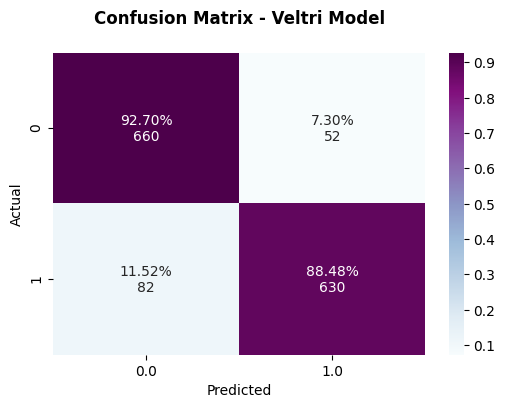

Sensitivity:     88.48%
Specificity:     92.70%
Accuracy:        90.59%
F1 Score:        90.39%
MCC:             81.25%
auROC:           96.12%


In [12]:
veltri_recreated_metrics = display_conf_matrix(y_test_VELT_df, V_mod_pred_labels, V_mod_pred, 'Veltri Model', 'Figures/VELTRI/Veltri_Model_CM.png')

##**BERT Model:**

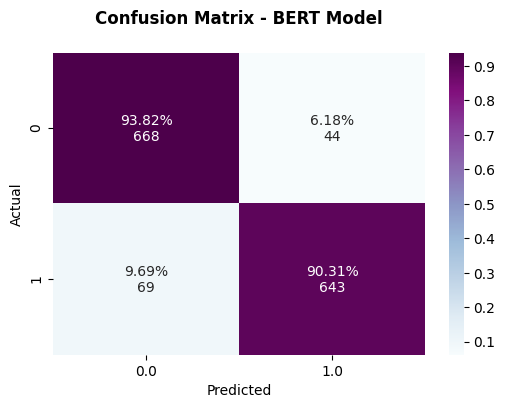

Sensitivity:     90.31%
Specificity:     93.82%
Accuracy:        92.06%
F1 Score:        91.92%
MCC:             84.18%
auROC:           97.29%


In [13]:
bert_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_BERT_Model_92.06')
X_test = load_VELTRI_X_data('BERT')
bert_mod_pred = bert_model_VELT.predict(X_test, batch_size=8)
bert_mod_pred_labels = convert_preds(bert_mod_pred)
bert_VELT_metrics = display_conf_matrix(y_test_VELT_df, bert_mod_pred_labels, bert_mod_pred, 'BERT Model', 'Figures/VELTRI/BERT_Model_CM.png')

##**BERT BFD Model:**

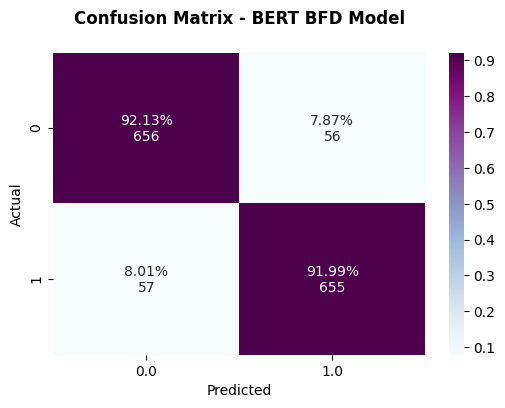

Sensitivity:     91.99%
Specificity:     92.13%
Accuracy:        92.06%
F1 Score:        92.06%
MCC:             84.13%
auROC:           97.55%


In [14]:
bert_bfd_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_BERT_BFD_Model_92.06')
X_test = load_VELTRI_X_data('BERT_BFD')
bert_bfd_mod_pred = bert_bfd_model_VELT.predict(X_test, batch_size=8)
bert_bfd_mod_pred_labels = convert_preds(bert_bfd_mod_pred)
bert_bfd_metrics = display_conf_matrix(y_test_VELT_df, bert_bfd_mod_pred_labels, bert_bfd_mod_pred, 'BERT BFD Model', 'Figures/VELTRI/BERT_BFD_Model_CM.png')

##**T5XL UNI Model:**

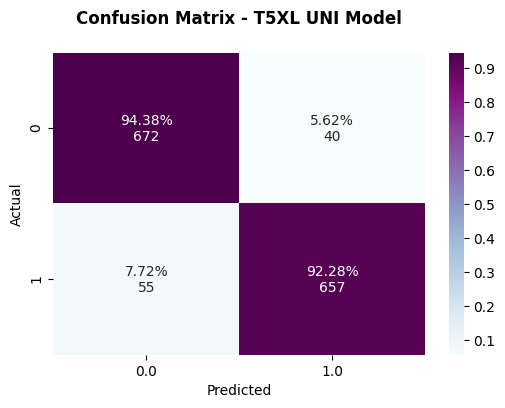

Sensitivity:     92.28%
Specificity:     94.38%
Accuracy:        93.33%
F1 Score:        93.26%
MCC:             86.68%
auROC:           97.89%


In [15]:
t5xl_uni_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_T5XL_UNI_Model_93.33')
X_test = load_VELTRI_X_data('T5XL_UNI')
t5xl_uni_mod_pred = t5xl_uni_model_VELT.predict(X_test, batch_size=8)
t5xl_uni_mod_pred_labels = convert_preds(t5xl_uni_mod_pred)
t5xl_uni_metrics = display_conf_matrix(y_test_VELT_df, t5xl_uni_mod_pred_labels, t5xl_uni_mod_pred, 'T5XL UNI Model', 'Figures/VELTRI/T5XL_UNI_Model_CM.png')

##**T5XL BFD Model:**

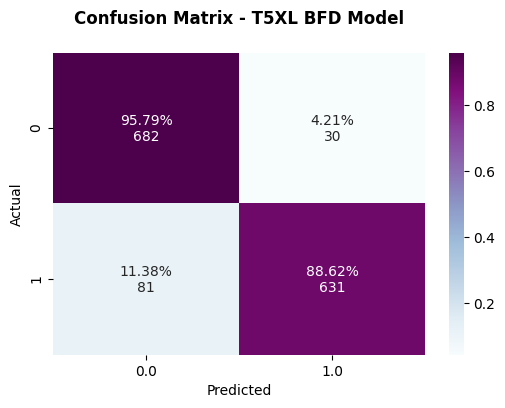

Sensitivity:     88.62%
Specificity:     95.79%
Accuracy:        92.21%
F1 Score:        91.92%
MCC:             84.63%
auROC:           97.41%


In [16]:
t5xl_bfd_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_T5XL_BFD_Model_92.21')
X_test = load_VELTRI_X_data('T5XL_BFD')
t5xl_bfd_mod_pred = t5xl_bfd_model_VELT.predict(X_test, batch_size=8)
t5xl_bfd_mod_pred_labels = convert_preds(t5xl_bfd_mod_pred)
t5xl_bfd_metrics = display_conf_matrix(y_test_VELT_df, t5xl_bfd_mod_pred_labels, t5xl_bfd_mod_pred, 'T5XL BFD Model', 'Figures/VELTRI/T5XL_BFD_Model_CM.png')

##**XLNET Model:**

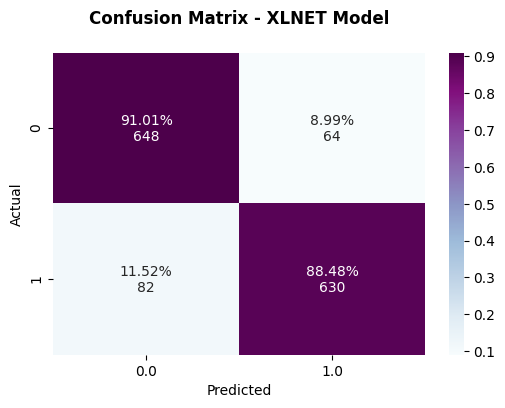

Sensitivity:     88.48%
Specificity:     91.01%
Accuracy:        89.75%
F1 Score:        89.62%
MCC:             79.52%
auROC:           95.78%


In [17]:
xlnet_model_VELT = keras.models.load_model('Keras_Models/VELTRI/Best_XLNET_Model_89.75')
X_test = load_VELTRI_X_data('XLNET')
xlnet_mod_pred = xlnet_model_VELT.predict(X_test, batch_size=8)
xlnet_mod_pred_labels = convert_preds(xlnet_mod_pred)
xlnet_metrics = display_conf_matrix(y_test_VELT_df, xlnet_mod_pred_labels, xlnet_mod_pred, 'XLNET Model', 'Figures/VELTRI/XLNET_Model_CM.png')

##**T5XL Uni Model - Trained on Independent Training and Validation Data:**

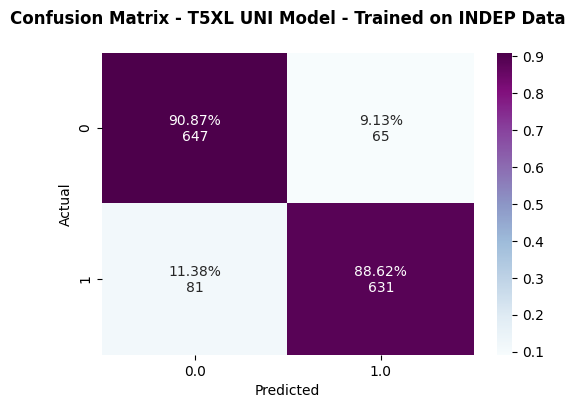

Sensitivity:     88.62%
Specificity:     90.87%
Accuracy:        89.75%
F1 Score:        89.63%
MCC:             79.51%
auROC:           95.51%


In [19]:
T5XL_UNI_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_T5XL_UNI_Model_88.26')
X_test = load_VELTRI_X_data('T5XL_UNI_INDEP')
T5XL_UNI_mod_pred = T5XL_UNI_model_INDEP.predict(X_test, batch_size=8)
T5XL_UNI_mod_pred_labels = convert_preds(T5XL_UNI_mod_pred)
T5XL_UNI_metrics = display_conf_matrix(y_test_VELT_df, T5XL_UNI_mod_pred_labels, T5XL_UNI_mod_pred, 'T5XL UNI Model - Trained on INDEP Data', 'Figures/VELTRI/T5XL_UNI_INDEP_Model_CM.png')

## **Creating Dataframe of Metrics:**

In [18]:
metrics_VELTRI_dataset = pd.DataFrame({'Veltri Recr. - DNN*':veltri_recreated_metrics, 'BERT - DNN':bert_VELT_metrics, 'BERT BFD - DNN':bert_bfd_metrics, 
                           'T5XL UNI - DNN':t5xl_uni_metrics, 'T5XL BFD - DNN':t5xl_bfd_metrics, 'XLNET - DNN':xlnet_metrics
                            }).T.rename(
                        columns={0: "Sensitivity (%)", 1: "Specificity (%)", 2: "Accuracy (%)", 
                                 3: "F1 Score (%)", 4: "MCC (%)", 5: "auROC (%)"})
metrics_VELTRI_dataset

,Sensitivity (%),Specificity (%),Accuracy (%),F1 Score (%),MCC (%),auROC (%)
Veltri Recr. - DNN*,88.483146,92.696629,90.589888,90.387374,81.251932,96.115449
BERT - DNN,90.308989,93.820225,92.064607,91.922802,84.181122,97.293192
BERT BFD - DNN,91.994382,92.134831,92.064607,92.059030,84.129296,97.548053
T5XL UNI - DNN,92.275281,94.382022,93.328652,93.257630,86.676541,97.889215
T5XL BFD - DNN,88.623596,95.786517,92.205056,91.915513,84.627493,97.412140
XLNET - DNN,88.483146,91.011236,89.747191,89.615932,79.519798,95.781783


In [19]:
metrics_VELTRI_dataset.to_csv('Results/VELTRI_DATASET_ALL_MODEL_METRICS.csv')

#**Testing on the Independent Dataset:**

##**Import Test Dataset:**

###**X Data:**

In [4]:
def load_INDEP_X_data(lang_model):
  if lang_model =='BERT':
    X_test = np.load('Embeddings/BERT/BERT_INDEP_X_TEST.npy')
  elif lang_model =='BERT_BFD':
    X_test = np.load('Embeddings/BERT_BFD/BERT_BFD_INDEP_X_TEST.npy')
  elif lang_model =='T5XL_UNI':
    X_test = np.load('Embeddings/T5XL_UNI/T5XL_UNI_INDEP_X_TEST.npy')
  elif lang_model =='T5XL_BFD':
    X_test = np.load('Embeddings/T5XL_BFD/T5XL_BFD_INDEP_X_TEST.npy')
  elif lang_model =='XLNET':
    X_test = np.load('Embeddings/XLNET/XLNET_INDEP_X_TEST.npy')
  elif lang_model =='VELTRI':
    X_test = np.load('Datasets/INDEP/X_test_VELTRI_Conv.npy')

  # The Veltri method does not require X Test to be reshaped for the model:
  if lang_model !='VELTRI':
    X_test = X_test.reshape(X_test.shape[0], 255, 1024, 1)
  
  return X_test

###**Y Data:**

In [15]:
y_test_INDEP = pd.read_csv('Datasets/INDEP/y_test.csv', header=None)[0]

##**Veltri Model:**

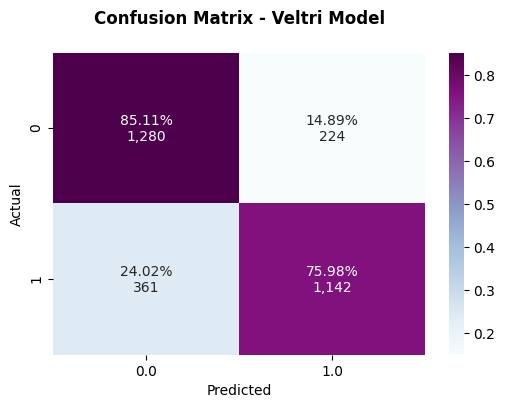

Sensitivity:     75.98%
Specificity:     85.11%
Accuracy:        80.55%
F1 Score:        79.61%
MCC:             61.34%
auROC:           85.82%


In [22]:
# Load best saved model built using the Veltri method:
veltri_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_Veltri_Model_80.7')
# Load the X Test data in the manner that the model expects to receive:
X_test = load_INDEP_X_data('VELTRI')
# Using the Model to predict values based on the test set:
V_mod_pred = veltri_model_INDEP.predict(X_test, batch_size=8)
# Converting predictions to binary, serialised format for input to metrics function below:
V_mod_pred_labels = convert_preds(V_mod_pred)
# Displaying and Saving Metrics
veltri_recreated_metrics = display_conf_matrix(y_test_INDEP, V_mod_pred_labels, V_mod_pred, 'Veltri Model', 'Figures/INDEP/Veltri_Model_CM.png')

##**BERT Model:**

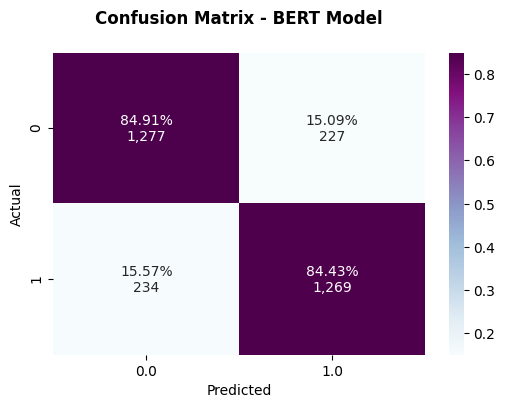

Sensitivity:     84.43%
Specificity:     84.91%
Accuracy:        84.67%
F1 Score:        84.63%
MCC:             69.34%
auROC:           90.84%


In [23]:
BERT_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_BERT_Model_84.67')
X_test = load_INDEP_X_data('BERT')
BERT_mod_pred = BERT_model_INDEP.predict(X_test, batch_size=8)
BERT_mod_pred_labels = convert_preds(BERT_mod_pred)
BERT_metrics = display_conf_matrix(y_test_INDEP, BERT_mod_pred_labels, BERT_mod_pred, 'BERT Model', 'Figures/INDEP/BERT_Model_CM.png')

##**BERT BFD Model:**

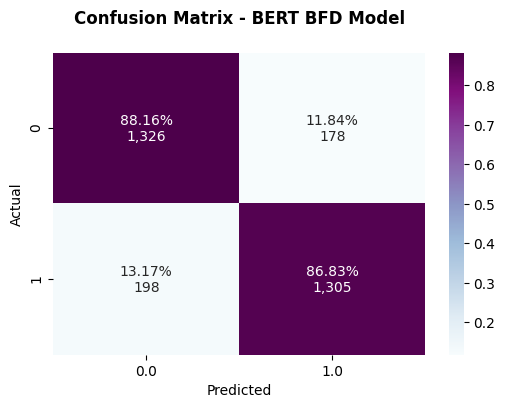

Sensitivity:     86.83%
Specificity:     88.16%
Accuracy:        87.50%
F1 Score:        87.41%
MCC:             75.00%
auROC:           93.58%


In [24]:
BERT_BFD_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_BERT_BFD_Model_87.50')
X_test = load_INDEP_X_data('BERT_BFD')
BERT_BFD_mod_pred = BERT_BFD_model_INDEP.predict(X_test, batch_size=8)
BERT_BFD_mod_pred_labels = convert_preds(BERT_BFD_mod_pred)
BERT_BFD_metrics = display_conf_matrix(y_test_INDEP, BERT_BFD_mod_pred_labels, BERT_BFD_mod_pred, 'BERT BFD Model', 'Figures/INDEP/BERT_BFD_Model_CM.png')

##**T5XL UNI Model:**

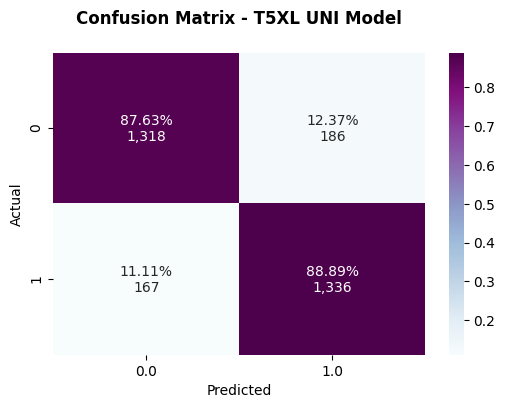

Sensitivity:     88.89%
Specificity:     87.63%
Accuracy:        88.26%
F1 Score:        88.33%
MCC:             76.53%
auROC:           94.66%


In [25]:
T5XL_UNI_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_T5XL_UNI_Model_88.26')
X_test = load_INDEP_X_data('T5XL_UNI')
T5XL_UNI_mod_pred = T5XL_UNI_model_INDEP.predict(X_test, batch_size=8)
T5XL_UNI_mod_pred_labels = convert_preds(T5XL_UNI_mod_pred)
T5XL_UNI_metrics = display_conf_matrix(y_test_INDEP, T5XL_UNI_mod_pred_labels, T5XL_UNI_mod_pred, 'T5XL UNI Model', 'Figures/INDEP/T5XL_UNI_Model_CM.png')

##**T5XL BFD Model:**

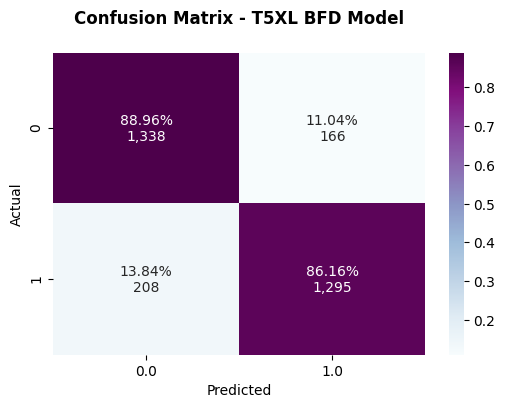

Sensitivity:     86.16%
Specificity:     88.96%
Accuracy:        87.56%
F1 Score:        87.38%
MCC:             75.15%
auROC:           93.68%


In [26]:
T5XL_BFD_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_T5XL_BFD_Model_87.56')
X_test = load_INDEP_X_data('T5XL_BFD')
T5XL_BFD_mod_pred = T5XL_BFD_model_INDEP.predict(X_test, batch_size=8)
T5XL_BFD_mod_pred_labels = convert_preds(T5XL_BFD_mod_pred)
T5XL_BFD_metrics = display_conf_matrix(y_test_INDEP, T5XL_BFD_mod_pred_labels, T5XL_BFD_mod_pred, 'T5XL BFD Model', 'Figures/INDEP/T5XL_BFD_Model_CM.png')

##**XLNET Model:**

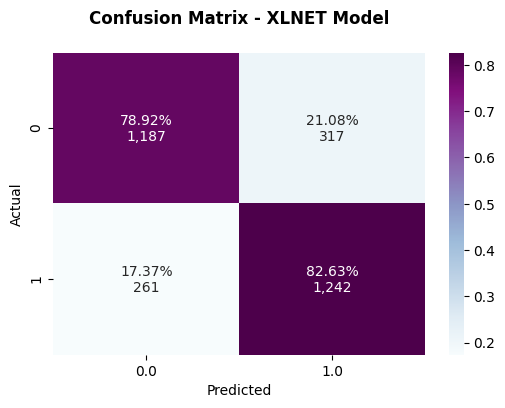

Sensitivity:     82.63%
Specificity:     78.92%
Accuracy:        80.78%
F1 Score:        81.12%
MCC:             61.60%
auROC:           88.87%


In [27]:
XLNET_model_INDEP = keras.models.load_model('Keras_Models/INDEP/Best_XLNET_Model_80.78')
X_test = load_INDEP_X_data('XLNET')
XLNET_mod_pred = XLNET_model_INDEP.predict(X_test, batch_size=8)
XLNET_mod_pred_labels = convert_preds(XLNET_mod_pred)
XLNET_metrics = display_conf_matrix(y_test_INDEP, XLNET_mod_pred_labels, XLNET_mod_pred, 'XLNET Model', 'Figures/INDEP/XLNET_Model_CM.png')

##**Combined Dataframe of Metrics:**

###**Importing Metrics from External AMP Prediction Servers:**

In [28]:
external_pred_metrics = pd.read_csv('Results/External_Pred_Metrics.csv')

In [29]:
external_pred_metrics

,Unnamed: 0,Sensitivity (%),Specificity (%),Accuracy (%),F1 Score (%),MCC (%),auROC (%)
0,amPEP,56.620093,43.484043,50.049884,53.121099,0.105046,NaN
1,CAMP-ANN,77.511643,72.539894,75.024942,75.624797,50.113094,NaN
2,CAMP-DA,81.037924,71.409574,76.222148,77.308791,52.691414,80.157969
3,CAMP-RF,84.697272,72.739362,78.716329,79.912116,57.850396,83.049725
4,CAMP-SVM,83.033932,71.875000,77.452611,78.638941,55.252884,80.272279
5,iAMP-2L,76.180971,74.601064,75.390755,75.577558,50.788237,NaN
6,iAMPpred,89.554225,55.917553,72.730296,76.651481,48.282540,82.276228
7,Veltri-DNN,90.086494,66.954787,78.516794,80.739416,58.628739,86.454861


###**Combining Metrics Found above on the Independent Dataset:**

In [30]:
metrics_INDEP_dataset = pd.DataFrame({'Veltri Recr. - DNN*':veltri_recreated_metrics, 'BERT - DNN':BERT_metrics, 'BERT BFD - DNN':BERT_BFD_metrics, 
                           'T5XL UNI - DNN':T5XL_UNI_metrics, 'T5XL BFD - DNN':T5XL_BFD_metrics, 'XLNET - DNN':XLNET_metrics
                            }).T.rename(
                        columns={0: "Sensitivity (%)", 1: "Specificity (%)", 2: "Accuracy (%)", 
                                 3: "F1 Score (%)", 4: "MCC (%)", 5: "auROC (%)"})
metrics_INDEP_dataset

,Sensitivity (%),Specificity (%),Accuracy (%),F1 Score (%),MCC (%),auROC (%)
Veltri Recr. - DNN*,75.981371,85.106383,80.545394,79.609620,61.344824,85.815050
BERT - DNN,84.431138,84.906915,84.669105,84.628209,69.338911,90.839907
BERT BFD - DNN,86.826347,88.164894,87.495843,87.407904,74.998209,93.584418
T5XL UNI - DNN,88.888889,87.632979,88.260725,88.330579,76.527657,94.657405
T5XL BFD - DNN,86.161011,88.962766,87.562355,87.381916,75.153805,93.675238
XLNET - DNN,82.634731,78.922872,80.778184,81.123449,61.599583,88.872654


In [31]:
metrics_INDEP_dataset.to_csv('Results/INDEP_DATASET_ALL_MODEL_METRICS.csv')

###**Concatenating the Two Dataframes:**

In [32]:
comb_metrics_df = pd.concat([external_pred_metrics, metrics_INDEP_dataset], axis=0)
comb_metrics_df = comb_metrics_df.rename(columns={comb_metrics_df.columns[0]: 'Method'})
comb_metrics_df

,Method,Sensitivity (%),Specificity (%),Accuracy (%),F1 Score (%),MCC (%),auROC (%)
0,amPEP,56.620093,43.484043,50.049884,53.121099,0.105046,NaN
1,CAMP-ANN,77.511643,72.539894,75.024942,75.624797,50.113094,NaN
2,CAMP-DA,81.037924,71.409574,76.222148,77.308791,52.691414,80.157969
3,CAMP-RF,84.697272,72.739362,78.716329,79.912116,57.850396,83.049725
4,CAMP-SVM,83.033932,71.875000,77.452611,78.638941,55.252884,80.272279
5,iAMP-2L,76.180971,74.601064,75.390755,75.577558,50.788237,NaN
6,iAMPpred,89.554225,55.917553,72.730296,76.651481,48.282540,82.276228
7,Veltri-DNN,90.086494,66.954787,78.516794,80.739416,58.628739,86.454861
Veltri Recr. - DNN*,NaN,75.981371,85.106383,80.545394,79.609620,61.344824,85.815050
BERT - DNN,NaN,84.431138,84.906915,84.669105,84.628209,69.338911,90.839907


In [33]:
comb_metrics_df.to_csv('Results/INDEP_DATASET_ALL_INT_AND_EXT_METRICS.csv')

# **Plotting ROC Curves:**

##**Veltri Dataset Results ROC Curves:**

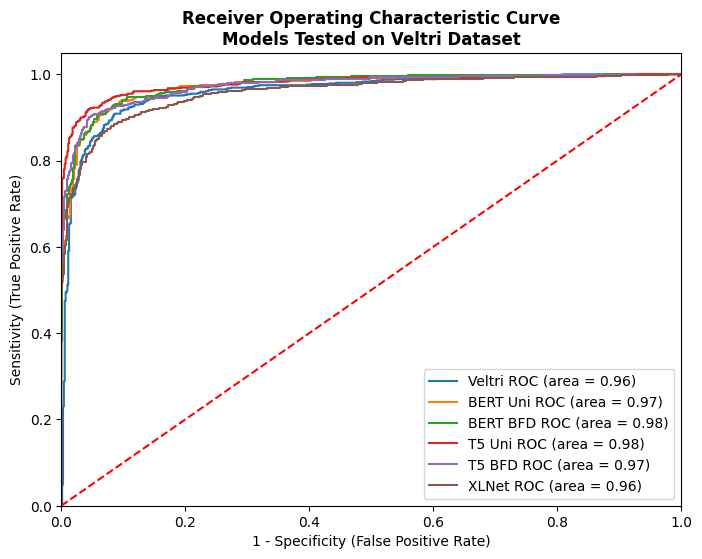

In [14]:
# code source: https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python

plt.figure(figsize=(8,6), dpi=100)

clf1 = keras.models.load_model('Keras_Models/VELTRI/Best_Veltri_Model_90.6')
clf2 = keras.models.load_model('Keras_Models/VELTRI/Best_BERT_Model_92.06')
clf3 = keras.models.load_model('Keras_Models/VELTRI/Best_BERT_BFD_Model_92.06')
clf4 = keras.models.load_model('Keras_Models/VELTRI/Best_T5XL_UNI_Model_93.33')
clf5 = keras.models.load_model('Keras_Models/VELTRI/Best_T5XL_BFD_Model_92.21')
clf6 = keras.models.load_model('Keras_Models/VELTRI/Best_XLNET_Model_89.75')

models = [
{
    'label': 'Veltri',
    'model': clf1,
    'LM': 'VELTRI'
},
{'label': 'BERT Uni', 'model': clf2, 'LM': 'BERT'}, {'label': 'BERT BFD', 'model': clf3, 'LM': 'BERT_BFD'}, 
{'label': 'T5 Uni', 'model': clf4, 'LM': 'T5XL_UNI'}, {'label': 'T5 BFD', 'model': clf5, 'LM': 'T5XL_BFD'}, 
{'label': 'XLNet', 'model': clf6, 'LM': 'XLNET'}, 
]

for m in models:
    model = m['model']
    x_test = load_VELTRI_X_data(m['LM'])
    y_pred = model.predict(x_test, batch_size=8) 
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_VELT_df, y_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test_VELT_df, y_pred)
# Plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic Curve\nModels Tested on Veltri Dataset', fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('Figures/VELTRI/ROC_Curves.png', bbox_inches='tight')
plt.show()   

##**Independent Dataset Results ROC Curves:**

In [11]:
def save_preds(model_loc, LM, save_file):
    clf = keras.models.load_model(model_loc)
    x_test = load_INDEP_X_data(LM)
    pred = clf.predict(x_test, batch_size=8)
    np.save(save_file, pred)

In [12]:
# Saving Prediction arrays from stored models:
save_preds('Keras_Models/INDEP/Best_Veltri_Model_80.7', 'VELTRI', 'Predictions/INDEP/INDEP_VELTRI_Model_Preds.npy')
save_preds('Keras_Models/INDEP/Best_BERT_Model_84.67', 'BERT', 'Predictions/INDEP/INDEP_BERT_Model_Preds.npy')
save_preds('Keras_Models/INDEP/Best_BERT_BFD_Model_87.50', 'BERT_BFD', 'Predictions/INDEP/INDEP_BERT_BFD_Model_Preds.npy')
save_preds('Keras_Models/INDEP/Best_T5XL_UNI_Model_88.26', 'T5XL_UNI', 'Predictions/INDEP/INDEP_T5XL_UNI_Model_Preds.npy')
save_preds('Keras_Models/INDEP/Best_T5XL_BFD_Model_87.56', 'T5XL_BFD', 'Predictions/INDEP/INDEP_T5XL_BFD_Model_Preds.npy')
save_preds('Keras_Models/INDEP/Best_XLNET_Model_80.78', 'XLNET', 'Predictions/INDEP/INDEP_XLNET_Model_Preds.npy')

In [13]:
# Loading Predictions, this ordering of operations saves memory when plotting ROC curves
pred1 =  np.load('Predictions/INDEP/INDEP_VELTRI_Model_Preds.npy')
pred2 =  np.load('Predictions/INDEP/INDEP_BERT_Model_Preds.npy')
pred3 =  np.load('Predictions/INDEP/INDEP_BERT_BFD_Model_Preds.npy')
pred4 =  np.load('Predictions/INDEP/INDEP_T5XL_UNI_Model_Preds.npy')
pred5 =  np.load('Predictions/INDEP/INDEP_T5XL_BFD_Model_Preds.npy')
pred6 =  np.load('Predictions/INDEP/INDEP_XLNET_Model_Preds.npy')

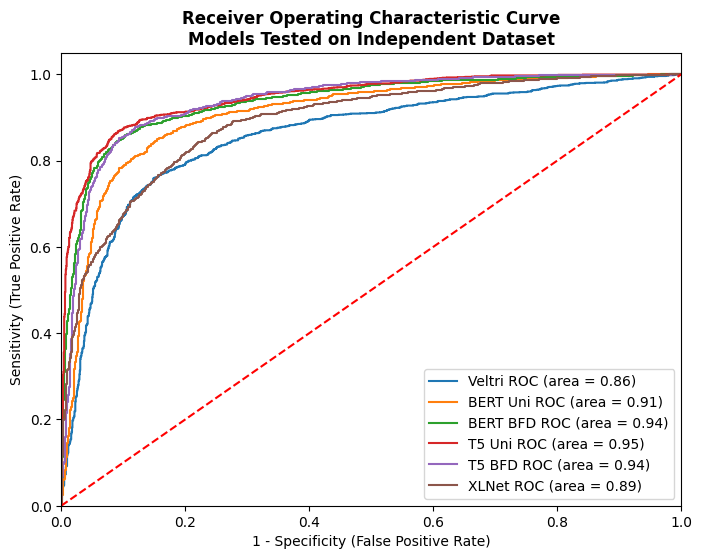

In [16]:
plt.figure(figsize=(8,6), dpi=100)

models = [
{
    'label': 'Veltri',
    'pred': pred1
},
{'label': 'BERT Uni', 'pred': pred2}, {'label': 'BERT BFD', 'pred': pred3}, 
{'label': 'T5 Uni', 'pred': pred4}, {'label': 'T5 BFD',  'pred': pred5}, 
{'label': 'XLNet', 'pred': pred6}, 
]

for m in models:
    y_pred = m['pred']
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_INDEP, y_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test_INDEP, y_pred)
# Plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic Curve\nModels Tested on Independent Dataset', fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('Figures/INDEP/ROC_Curves.png', bbox_inches='tight')
plt.show()

#**Testing Accuracy/Size/Time-Taken Trade-offs:**

In [5]:
x_test_T5XL_UNI = load_INDEP_X_data('T5XL_UNI')
x_test_BERT_BFD = load_INDEP_X_data('BERT_BFD')

##**T5XL Load Model and Predict Time:**

In [6]:
start_time = time.time()

# Load Model:
T5_Model = keras.models.load_model('Keras_Models/INDEP/Best_T5XL_UNI_Model_88.26')

# Predict based on X Data:
T5_preds = T5_Model.predict(x_test_T5XL_UNI, batch_size=8)

print("--- %s seconds ---" % (time.time() - start_time))

--- 165.7531816959381 seconds ---


In [7]:
start_time = time.time()

# Load Model:
BERT_BFD_Model = keras.models.load_model('Keras_Models/INDEP/Best_BERT_BFD_Model_87.50')

# Predict based on X Data:
BERT_BFD_preds = BERT_BFD_Model.predict(x_test_BERT_BFD, batch_size=8)

print("--- %s seconds ---" % (time.time() - start_time))

--- 34.392088174819946 seconds ---
